# Random Forests Classifier ROC curve and other analysis

In [2]:
import bisect
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix
from sklearn.metrics import f1_score, make_scorer, matthews_corrcoef, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import shuffle

%matplotlib inline

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Helper Functions

In [11]:
def line(x_coords, y_coords):
    """
    Given a pair of coordinates (x1,y2), (x2,y2), define the line equation. Note that this is the entire line vs. t
    the line segment.

    Parameters
    ----------
    x_coords: Numpy array of 2 points corresponding to x1,x2
    x_coords: Numpy array of 2 points corresponding to y1,y2

    Returns
    -------
    (Gradient, intercept) tuple pair
    """    
    if (x_coords.shape[0] < 2) or (y_coords.shape[0] < 2):
        raise ValueError('At least 2 points are needed to compute'
                         ' area under curve, but x.shape = %s' % p1.shape)
    if ((x_coords[0]-x_coords[1]) == 0):
        raise ValueError("gradient is infinity")
    gradient = (y_coords[0]-y_coords[1])/(x_coords[0]-x_coords[1])
    intercept = y_coords[0] - gradient*1.0*x_coords[0]
    return (gradient, intercept)

def x_val_line_intercept(gradient, intercept, x_val):
    """
    Given a x=X_val vertical line, what is the intersection point of that line with the 
    line defined by the gradient and intercept. Note: This can be further improved by using line
    segments.

    Parameters
    ----------
    gradient
    intercept

    Returns
    -------
    (x_val, y) corresponding to the intercepted point. Note that this will always return a result.
    There is no check for whether the x_val is within the bounds of the line segment.
    """    
    y = gradient*x_val + intercept
    return (x_val, y)

def get_fpr_tpr_for_thresh(fpr, tpr, thresh):
    """
    Derive the partial ROC curve to the point based on the fpr threshold.

    Parameters
    ----------
    fpr: Numpy array of the sorted FPR points that represent the entirety of the ROC.
    tpr: Numpy array of the sorted TPR points that represent the entirety of the ROC.
    thresh: The threshold based on the FPR to extract the partial ROC based to that value of the threshold.

    Returns
    -------
    thresh_fpr: The FPR points that represent the partial ROC to the point of the fpr threshold.
    thresh_tpr: The TPR points that represent the partial ROC to the point of the fpr threshold
    """    
    p = bisect.bisect_left(fpr, thresh)
    thresh_fpr = fpr[:p+1].copy()
    thresh_tpr = tpr[:p+1].copy()
    g, i = line(fpr[p-1:p+1], tpr[p-1:p+1])
    new_point = x_val_line_intercept(g, i, thresh)
    thresh_fpr[p] = new_point[0]
    thresh_tpr[p] = new_point[1]
    return thresh_fpr, thresh_tpr


def partial_auc_scorer(fpr, tpr, decile=1):
    """
    Derive the AUC based of the partial ROC curve from FPR=0 to FPR=decile threshold.

    Parameters
    ----------
    y_actual: numpy array of the actual labels.
    y_pred: Numpy array of The predicted probability scores.
    decile: The threshold based on the FPR to extract the partial ROC based to that value of the threshold.

    Returns
    -------
    AUC of the partial ROC. A value that ranges from 0 to 1.
    """        
    fpr_thresh, tpr_thresh = get_fpr_tpr_for_thresh(fpr, tpr, decile)
    return auc(fpr_thresh, tpr_thresh)

## Import  and normalize data

In [6]:
NUMBER_OF_IMGS = 410
NUMBER_OF_MASSES = 107
test_set_perc = 0.5
# Loading of data and splitting in groups according to images
# Regions of the same image will stay in the same Pandas Dataframe in the end (dataset_df1 or dataset_df2)

# without lbp
file_path = "feature-tables/train-data_1527086478.csv"

data = pd.read_csv(file_path, index_col=0)
data_per_imgfile = list(data['img_name'].unique())
np.random.shuffle(data_per_imgfile)

test_set_len = int(test_set_perc * len(data_per_imgfile))
print(f"Number of images in the test set {test_set_len}")

train_imgs = data_per_imgfile[test_set_len:]
test_imgs = data_per_imgfile[:test_set_len]
print(f"Number of images in the train set {len(train_imgs)}")

# sampling of the original data set according to images in train/test subsets
data_train = data[data["img_name"].isin(train_imgs)]
data_test = data[data["img_name"].isin(test_imgs)]
print(f"Number of train regions {len(data_train)}")
print(f"Number of test regions {len(data_test)}")


# average number of ROIs per image
# we need to do simple averaging since mass images have fprs as well
reg_per_img = len(data)/(NUMBER_OF_IMGS)
print(f"Regions per image {reg_per_img}")

data_train.head()

Number of images in the test set 205
Number of images in the train set 205
Number of train regions 3164
Number of test regions 3212
Regions per image 15.551219512195122


,perimeter,area,circularity,ac,shape_factor,mean NRL,SD NRL,Ratio SD NRL and mean RL,entropy NRL,NCPS,...,contrast,uniformity,homogeneity,energy,dissimilarity,gradient mean,gradient SD,gradient skewness,class_id,img_name
0,11915.436843,471594.5,23.957491,19684.636019,301.058717,0.483254,0.213549,0.000467,7.449049,0.000577,...,239.572983,0.426164,0.671548,0.652812,7.449298,34366.227416,31496.721095,-0.101256,-1.0,50997223_9054942f7be52dd9_MG_L_ML_ANON
1,1456.835567,25008.5,6.753417,3703.088402,84.865940,0.469930,0.218902,0.001773,5.244906,0.005927,...,243.873860,0.422889,0.670013,0.650299,7.518958,35640.511737,31296.812258,-0.196797,-1.0,50997223_9054942f7be52dd9_MG_L_ML_ANON
2,552.568541,12930.0,1.879161,6880.731345,23.614230,0.691730,0.110095,0.001784,4.509496,0.006628,...,444.902055,0.123459,0.385570,0.351367,13.889922,24526.076087,30648.610934,0.539966,-1.0,50997223_9054942f7be52dd9_MG_L_ML_ANON
3,489.254833,8677.0,2.195284,3952.563082,27.586757,0.616047,0.136988,0.002801,4.318305,0.006962,...,478.401209,0.098406,0.350068,0.313697,14.784741,21939.337662,29625.922161,0.747009,-1.0,50997223_9054942f7be52dd9_MG_L_ML_ANON
4,412.183765,6257.5,2.160583,2896.208448,27.150692,0.652244,0.192145,0.004071,4.048747,0.003196,...,466.970919,0.100183,0.353384,0.316516,14.575328,28659.866667,31568.955902,0.268713,-1.0,50997223_9054942f7be52dd9_MG_L_ML_ANON


In [7]:
# Converts from dataframe to numpy array
# Change here (or copy the code) if you want to select only some of the features to the array
# (only texture features, only geomatrical features...)

# Conversion from pandas dataframe to numpy array
# Keeps all the features from the original csv file
feature_train = data_train.drop(['class_id','img_name'], axis=1)
target_train  = data_train['class_id']
x_train = feature_train.as_matrix()
y_train = target_train.as_matrix()

feature_test = data_test.drop(['class_id','img_name'], axis=1)
target_test  = data_test['class_id']
x_test = feature_test.as_matrix()
y_test = target_test.as_matrix()

# Shuflles the datasets and creates one variable with labels for all the samples
x_train, y_train = shuffle(x_train, y_train, random_state=None)
x_test, y_test = shuffle(x_test, y_test, random_state=None)
all_data = np.vstack((x_train, x_test))
all_labels = np.concatenate((y_test, y_train),axis=0)

# Data standardization for each dataset (two methods)
x_train = preprocessing.StandardScaler().fit_transform(x_train)
x_test = preprocessing.StandardScaler().fit_transform(x_test)
all_data = preprocessing.StandardScaler().fit_transform(all_data)
#dataset01_data = preprocessing.robust_scale(dataset01_data)fit_transform
#dataset02_data = preprocessing.robust_scale(dataset02_data)

print(y_train.shape)
print(y_test.shape)

all_labels

(3164,)
(3212,)


array([-1., -1., -1., ..., -1., -1., -1.])

## Classifier with manually selected parameters

### Training

In [13]:
# 85% of masses detected, 85% accuracy, f1_score=20%, mathew_coef=25%
# Parameter selection by me, fit to the train data set firts
clf_me_train = RandomForestClassifier(n_estimators=1000, #500
                             max_features='sqrt',
                             min_samples_leaf=50,
                             class_weight='balanced',
                             oob_score=True)

clf_me_train.fit(x_train, y_train)

# Now fit to the test data set, classifier the same
clf_me_test = RandomForestClassifier(n_estimators=1000,
                             max_features='sqrt',
                             min_samples_leaf=50,
                             class_weight='balanced',
                             oob_score=True)

clf_me_test.fit(x_test, y_test)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=50,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

### Analysis

In [14]:
prob_me_train = clf_me_train.predict_proba(x_test)
pred_me_train = clf_me_train.predict(x_test)

prob_me_test = clf_me_test.predict_proba(x_train)
pred_me_test = clf_me_test.predict(x_train)

prob_me = np.vstack((prob_me_train, prob_me_test))
pred_me = np.concatenate((pred_me_train, pred_me_test), axis=0)

labels = np.concatenate((y_test, y_train))

Negative regions per image 15.282926829268293
Number of positive images 115, number of positive regions 110


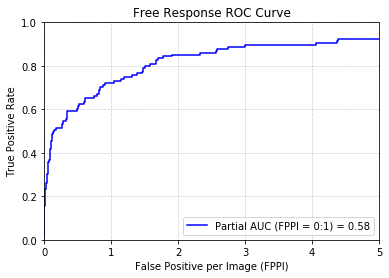

In [15]:
# Counts to adjust the TPR and to create the False Positive per Image
_, counts = np.unique(all_labels, return_counts=True)
num_img = 410
num_pos_img = 115
regions = all_labels.shape[0]
pos_reg = counts[1]
neg_reg = counts[0]
neg_reg_per_img = neg_reg / num_img

print(f"Negative regions per image {neg_reg_per_img}")
print(f"Number of positive images {num_pos_img}, number of positive regions {pos_reg}")

def get_roc(test_labels, out_probs):
    
    if (not isinstance(test_labels, list)) and (not isinstance(test_labels, tuple)):
        test_labels = (test_labels,)
    
    if (not isinstance(out_probs, list)) and (not isinstance(out_probs, tuple)):
        out_probs = (out_probs,)
        
    for i, labels_probs in enumerate(zip(test_labels, out_probs)):
        test_ls, out_prob = labels_probs
        fpr, tpr, _ = roc_curve(test_ls, out_prob[:,1], pos_label=1, drop_intermediate=True)
        roc_auc = auc(fpr, tpr)
        
        fpr = fpr * neg_reg_per_img
        tpr = tpr * pos_reg / num_pos_img
        
        # Calculates Partial AUC
        partial_auc = partial_auc_scorer(fpr, tpr, 1)
        
#         plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}, ROC #{i+1}')
        plt.plot(fpr, tpr, 'b',label='Partial AUC (FPPI = 0:1) = %0.2f'% partial_auc)
        plt.legend(loc='lower right')

    plt.title('Free Response ROC Curve')
    plt.xlim([-0,5])
    plt.ylim([-0,1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive per Image (FPPI)')
    plt.grid(color='k', linestyle='dotted', linewidth=0.5, alpha=0.5)
    plt.show()


get_roc(all_labels, prob_me)

In [16]:
# Runs the classifier and outputs the metrics
def metrics_report(labels, predictions):
    print(f'Number of masses {sum(labels > 0)}')
    print(f'Number of non-masses {sum(labels < 0)}')
    print('Confusion matrix:')
    print(confusion_matrix(labels, predictions, labels=[1,-1]),'\n')
    print('Classification report:')
    print(classification_report(labels, predictions, labels=[1,-1]),'\n')
    print('Accuracy:')
    print(accuracy_score(labels, predictions),'\n')
    print('Matthew Correlation Coefficient:')
    print(matthews_corrcoef(labels, predictions),'\n')


metrics_report(all_labels, pred_me)

Number of masses 110
Number of non-masses 6266
Confusion matrix:
[[  83   27]
 [ 428 5838]] 

Classification report:
             precision    recall  f1-score   support

          1       0.16      0.75      0.27       110
         -1       1.00      0.93      0.96      6266

avg / total       0.98      0.93      0.95      6376
 

Accuracy:
0.9286386449184442 

Matthew Correlation Coefficient:
0.32909653389435106 



## Optimized parameters by GridSerachCV

## Training

In [8]:
# Parameter selection based on GridSearchCV masses 51%,, accuracy=97%, f1_score=20%, mather_coef=18%
clf_opt_train = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=16, max_features=4,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=8,
            min_samples_split=8, min_weight_fraction_leaf=0.0,
            n_estimators=9, n_jobs=-1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

# Fit to the data. 
clf_opt_train.fit(x_train, y_train)

clf_opt_test = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=16, max_features=4,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=8,
            min_samples_split=8, min_weight_fraction_leaf=0.0,
            n_estimators=9, n_jobs=-1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

clf_opt_test.fit(x_test, y_test)

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:458: Runtim

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=16, max_features=4,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=8,
            min_samples_split=8, min_weight_fraction_leaf=0.0,
            n_estimators=9, n_jobs=-1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

### Analysis

In [9]:
prob_opt_train = clf_opt_train.predict_proba(x_test)
pred_opt_train = clf_opt_train.predict(x_test)

prob_opt_test = clf_opt_test.predict_proba(x_train)
pred_opt_test = clf_opt_test.predict(x_train)

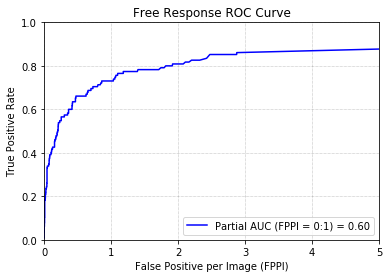

In [17]:
labels = np.concatenate((y_test, y_train))
probs = np.vstack((prob_opt_train, prob_opt_test))

get_roc(all_labels, probs)

In [18]:
metrics_report(y_test, pred_opt_train)

Number of masses 54
Number of non-masses 3158
Confusion matrix:
[[  40   14]
 [  67 3091]] 

Classification report:
             precision    recall  f1-score   support

          1       0.37      0.74      0.50        54
         -1       1.00      0.98      0.99      3158

avg / total       0.99      0.97      0.98      3212
 

Accuracy:
0.9747820672478207 

Matthew Correlation Coefficient:
0.5154968404612668 



In [49]:
run_kfold(clf_opt)

/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/okozyn/.conda/envs/immas/lib/python3.6/site-packages/scikit_learn-0.19.1-py3.6-linux-x86_64.egg/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encounte

Mean Accuracy: 0.9708863920099875
Mean F1 Score: 0.25666666666666665
Mean Matthew Correlation coefficient: 0.27050316908583305
